In this notebook we write the code to make the overlapping corner plots.

In [1]:
import corner
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from matplotlib.lines import Line2D


plt.rcdefaults()

First we load up all of the samples that we want to show:

In [2]:
import pickle

def log_probability(theta, nu, x, y, yerr):

    lp = log_prior(theta)

    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, nu, x, y, yerr)

def load_samples(file_path):
    with open(file_path, 'rb') as f:
        Dingo_sampler = pickle.load(f)
    
    Dingo_samples = Dingo_sampler.get_chain(flat = True)
    
    #The 1st index is theta_obs, the [-1st] idx is DL.
    #We want the [theta_obs, DL] for each of the lists in Dingo_samples
    
    Dingo_samples1 = [[float(Dingo_samples[i][1]), float(Dingo_samples[i][-1])] for i in range(len(Dingo_samples))]
    return Dingo_samples1

Load up the posteriors we want to plot below, and then make them into a list.

In [38]:
DL10_100_theta0_pi2 = load_samples('./with_ini/DL10_100_thetaobs0_pi2_sampler.pkl')
uninformed_theta = load_samples('./with_ini/Dingo_sampler.pkl')
theta_from_dingo = load_samples('./with_ini/Dingo_thetaObs_p227_1p19_sampler.pkl')
DLcheck = load_samples('./with_ini/DLcheck_sampler.pkl')

We put these into lists, along with the colors and labels we want to use.

In [39]:
list_of_samples = [DLcheck , DL10_100_theta0_pi2, uninformed_theta, theta_from_dingo]
colors = ['yellow', 'purple','purple', 'red']
labels = [r'38 < DL < 42, $0<\theta_{obs}<\frac{\pi}{2}$', r'10 < DL < 100, $0<\theta_{obs}<\frac{\pi}{2}$' , r'18.5 < DL < 45.4, $0<\theta_{obs}<\frac{\pi}{2}$', r'18.5 < DL < 45.4, $0.227<\theta_{obs}<1.19$']
labels = ['Dingo Placeholder', r'10 < DL < 100, $0<\theta_{obs}<\frac{\pi}{2}$' , r'18.5 < DL < 45.4, $0<\theta_{obs}<\frac{\pi}{2}$', r'18.5 < DL < 45.4, $0.227<\theta_{obs}<1.19$']

linestyles = ['-', '--', '-.']

The function that generates the corner plots:

In [46]:


def make_many_corners(list_of_samples = list_of_samples, names = labels, colors = colors, linestyles = linestyles, title = '68% confidence intervals', meshgrid_number = 50):

    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    list_of_samples = [np.array(samples) for samples in list_of_samples]

    list_of_thetaObs = [samples[:, 0] for samples in list_of_samples]
    list_of_DL = [samples[:, 1] for samples in list_of_samples]

    datasets = [(theta_obs, DL, name, color, .8, linestyle) for theta_obs, DL, name, color, linestyle in zip(list_of_thetaObs, list_of_DL, names, colors, linestyles)]

    # Gather all x and y values into single arrays for global min/max
    all_thetaObs = np.concatenate([np.array(x) for x, _, _, _, _, _ in datasets])
    all_DL = np.concatenate([np.array(y) for _, y, _, _, _, _ in datasets])
    
    # Compute global min/max for all datasets
    xmin, xmax = np.percentile(all_thetaObs, [1, 99])
    ymin, ymax = np.percentile(all_DL, [1, 99])
    
    # Set up the grid once, outside the loop
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, meshgrid_number),
        np.linspace(ymin, ymax, meshgrid_number)
    )
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    fig, ax = plt.subplots(figsize=(5, 4))
    
    for x, y, label, color, alpha, linestyle in datasets:
        samples = np.vstack([x, y])
        kde = gaussian_kde(samples)
        zz = kde(positions).reshape(xx.shape)
    
        # Find the value of the KDE that encloses 90% of the probability
        z_sorted = np.sort(zz.ravel())[::-1]
        cumulative = np.cumsum(z_sorted)
        cumulative /= cumulative[-1]
        level_90 = z_sorted[np.searchsorted(cumulative, 0.68)]
    
        # Draw the 90% contour for this dataset
        ax.contour(xx, yy, zz, levels=[level_90], colors=color, linewidths=1, label=label, alpha=alpha, linestyles = linestyle)
    
    # Add labels and legend
    ax.set_xlabel(r'$\theta_{obs}$ (rad)')
    ax.set_ylabel('$D_L$ (Mpc)')
    #ax.set_yscale('log')
    ax.set_title(title)
    
    legend_elements = [Line2D([0], [0], color=color, lw=1, label=label, alpha = alpha, linestyle = linestyle) for _, _, label, color, alpha, linestyle in datasets]
    plt.legend(handles = legend_elements, loc = 'lower center', bbox_to_anchor = (.5, -0.5), ncol = 1)
    

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Adjust the fraction as needed
    #plt.savefig('Hotokezaka_plot90.png', dpi=300, bbox_inches='tight')
    
    plt.show()


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

def make_many_corners_filled(list_of_samples, names, colors, linestyles, title='68% confidence intervals', meshgrid_number=50):
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    list_of_samples = [np.array(samples) for samples in list_of_samples]
    list_of_thetaObs = [samples[:, 0] for samples in list_of_samples]
    list_of_DL = [samples[:, 1] for samples in list_of_samples]

    datasets = [(theta_obs, DL, name, color, .8, linestyle) 
                for theta_obs, DL, name, color, linestyle 
                in zip(list_of_thetaObs, list_of_DL, names, colors, linestyles)]

    # Gather all x and y values into single arrays for global min/max
    all_thetaObs = np.concatenate([np.array(x) for x, _, _, _, _, _ in datasets])
    all_DL = np.concatenate([np.array(y) for _, y, _, _, _, _ in datasets])
    xmin, xmax = np.percentile(all_thetaObs, [1, 99])
    ymin, ymax = np.percentile(all_DL, [1, 99])

    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, meshgrid_number),
        np.linspace(ymin, ymax, meshgrid_number)
    )
    positions = np.vstack([xx.ravel(), yy.ravel()])

    fig, ax = plt.subplots(figsize=(5, 4))

    for x, y, label, color, alpha, linestyle in datasets:
        samples = np.vstack([x, y])
        kde = gaussian_kde(samples)
        zz = kde(positions).reshape(xx.shape)

        # Find the KDE value that encloses 90% of the probability
        z_sorted = np.sort(zz.ravel())[::-1]
        cumulative = np.cumsum(z_sorted)
        cumulative /= cumulative[-1]
        level_90 = z_sorted[np.searchsorted(cumulative, 0.68)]

        # Fill the region inside the 90% contour
        contourf = ax.contourf(
            xx, yy, zz, 
            levels=[level_90, zz.max()], 
            colors=[color], 
            alpha=0.3,  # adjust for fill transparency
            antialiased=True
        )
        # Optionally, draw the outline contour as well
        ax.contour(
            xx, yy, zz, 
            levels=[level_90], 
            colors=[color], 
            linewidths=1, 
            linestyles=linestyle, 
            alpha=alpha, 
            label=label
        )

    # Add labels and legend
    ax.set_xlabel(r'$\theta_{obs}$ (rad)')
    ax.set_ylabel('$D_L$ (Mpc)')
    ax.set_title(title)

    legend_elements = [
        Line2D([0], [0], color=color, lw=2, label=label, alpha=0.8, linestyle=linestyle)
        for _, _, label, color, _, linestyle in datasets
    ]
    plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(.5, -0.5), ncol=1)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()


/var/folders/1f/xb_k0m151dndtvb4fsk2kfg80000gq/T/ipykernel_91814/4097058173.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(


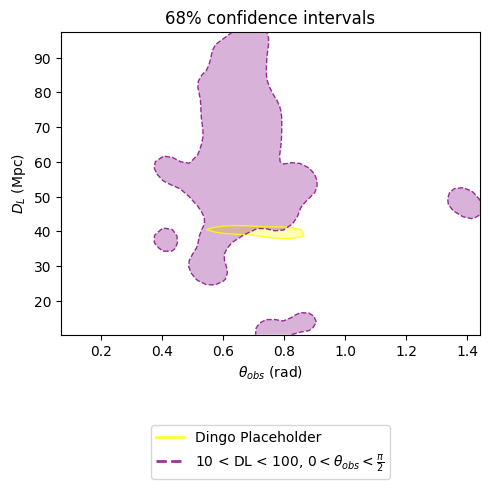

In [47]:
make_many_corners_filled(list_of_samples = list_of_samples[0:2], names = labels[0:2], colors = colors[0:2], linestyles = linestyles[0:2])

/var/folders/1f/xb_k0m151dndtvb4fsk2kfg80000gq/T/ipykernel_91814/1817763727.py:41: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, zz, levels=[level_90], colors=color, linewidths=1, label=label, alpha=alpha, linestyles = linestyle)


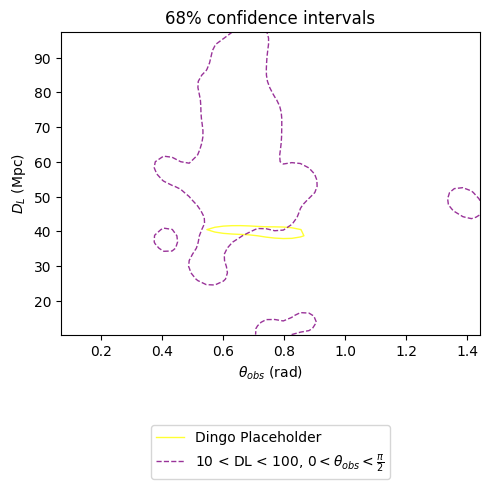

In [48]:
make_many_corners(list_of_samples = list_of_samples[0:2], names = labels[0:2], colors = colors[0:2], linestyles = linestyles[0:2])

In [ ]:
def make_many_corners_filled(list_of_samples, names, colors, linestyles, title=r'Dingo and Afterglowpy (Dingo $68\%$) priors', meshgrid_number=50):
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dingo_samples = list_of_samples[0]
    dingo_DLs = [dingo_samples['DL']]
    dingo_theta_obs = [dingo_samples['thetaObs']]

    
    list_of_samples = [np.array(samples) for samples in list_of_samples[1:]]

    list_of_thetaObs = [samples[:, 0] for samples in list_of_samples]
    list_of_DL = [samples[:, 1] for samples in list_of_samples]

    list_of_thetaObs = dingo_theta_obs + list_of_thetaObs
    list_of_DL = dingo_DLs + list_of_DL

    

    

    datasets = [(theta_obs, DL, name, color, .8, linestyle) 
                for theta_obs, DL, name, color, linestyle 
                in zip(list_of_thetaObs, list_of_DL, names, colors, linestyles)]

    # Gather all x and y values into single arrays for global min/max
    all_thetaObs = np.concatenate([np.array(x) for x, _, _, _, _, _ in datasets])
    all_DL = np.concatenate([np.array(y) for _, y, _, _, _, _ in datasets])
    xmin, xmax = np.percentile(all_thetaObs, [1, 99])
    ymin, ymax = np.percentile(all_DL, [1, 99])

    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, meshgrid_number),
        np.linspace(ymin, ymax, meshgrid_number)
    )
    positions = np.vstack([xx.ravel(), yy.ravel()])

    fig, ax = plt.subplots(figsize=(5, 4))

    for x, y, label, color, alpha, linestyle in datasets:
        samples = np.vstack([x, y])
        kde = gaussian_kde(samples)
        zz = kde(positions).reshape(xx.shape)

        # Find the KDE values for 68% and 95% containment
        z_sorted = np.sort(zz.ravel())[::-1]
        cumulative = np.cumsum(z_sorted)
        cumulative /= cumulative[-1]
        level_68 = z_sorted[np.searchsorted(cumulative, 0.68)]
        level_95 = z_sorted[np.searchsorted(cumulative, 0.95)]

        # Fill the 68% region
        ax.contourf(
            xx, yy, zz, 
            levels=[level_68, zz.max()], 
            colors=[color], 
            alpha=0.3,
            antialiased=True
        )

        # Draw the 68% outline (solid)
        ax.contour(
            xx, yy, zz, 
            levels=[level_68], 
            colors=[color], 
            linewidths=1.5, 
            linestyles=linestyle, 
            alpha=alpha, 
            label=label
        )
        # Draw the 95% outline (dashed, not filled)
        ax.contour(
            xx, yy, zz, 
            levels=[level_95], 
            colors=[color], 
            linewidths=1.2, 
            linestyles='dashed', 
            alpha=alpha,
            label=None
        )

    # Add labels and legend
    ax.set_xlabel(r'$\theta_{obs}$ (rad)')
    ax.set_ylabel('$D_L$ (Mpc)')
    ax.set_title(title)

    legend_elements = [
        Line2D([0], [0], color=color, lw=2, label=f"{label} 68%", alpha=0.8, linestyle=linestyle)
        for _, _, label, color, _, linestyle in datasets
    ] + [
        Line2D([0], [0], color='k', lw=1.2, label='95% contour', alpha=0.8, linestyle='dashed')
    ]
    plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(.5, -0.5), ncol=1)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)
    plt.show()